# 고양이 수염 스티커를 활용한 사진 꾸미기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math
# cv2 version : 4.5.3
# dlib version :  19.22.1

## step 1. 이미지 불러오기 

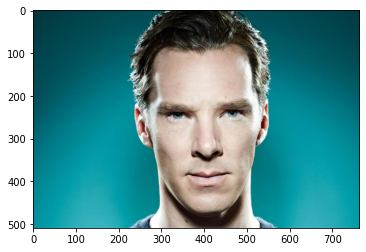

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/Benedict.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)

# plt.imshow 이전에 RGB 이미지로 바꾸기
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## step2.  Face lamdmark

In [3]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog 이용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb,1) 

rectangles[[(260, 171) (527, 439)]]


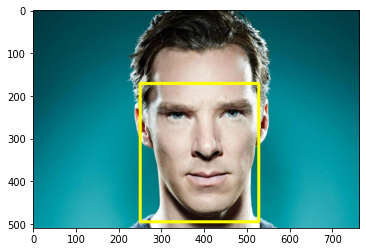

In [4]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l-10,t), (r,b+55), (0,255,255), 5, lineType=cv2.LINE_8)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

*  cv2.rectangle(img_show, (l-10,t), (r,b+55), (0,255,255), 5, lineType=cv2.LINE_8)
바운딩 박스의 크기 및 위치 조정
> left() 방향으로 10만큼 이동 
> bottom()방향으로 55만큼 크기 늘리기 

In [5]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [6]:
# landmark_predictor는 rgb 이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection반환 

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


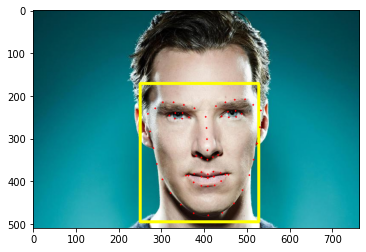

In [7]:
# 랜드마크 영상 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (10, 0, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## step 3. sticker apply

(512, 512, 3)


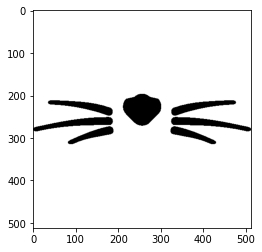

In [8]:
# 적용할 스티커 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_rgb = cv2.cvtColor(img_sticker,cv2.COLOR_BGR2RGB)

print (img_sticker.shape)
plt.imshow(img_sticker_rgb)
plt.show()

### 수염의 위치 지정 
1. 수염의 중앙은 양쪽 볼의 가운데 지점
> 볼의 가운데 지점은 양쪽 귀,눈,코,입의 가운데 지점

2. 코의 중심점 부위와 수염의 중앙을 일치 
> 코의 중심점 부위의 좌표점을 이용해 refined일때 refined_y를 설정하지 않는다 

*  refined_x,refined_y 설정하는 이유
> 이미지 시작점이 top -left부터이기 때문

### 방법1 . 수염의 중앙 =  볼의 가운데 지점

(x,y): (404,318)
(w,h): (268,268)
sticker shape : (268, 268, 3)
refined(x,y) : (270,184)


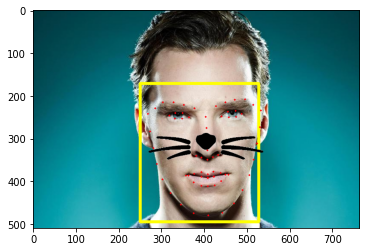

In [9]:
# 방법 1. 수염의 중앙은 볼의 가운데 지점
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x_list = [landmark[2][0],landmark[36][0],landmark[30][0],landmark[48][0],
              landmark[14][0],landmark[45][0],landmark[30][0],landmark[54][0]]
    y_list = [landmark[2][1],landmark[36][1],landmark[30][1],landmark[48][1],
              landmark[14][1],landmark[45][1],landmark[30][1],landmark[54][1]]
    
    x = int(np.mean(x_list)) # int : x_list의 mean의 값이 실수값이므로 정수로 변환
    y = int(np.mean(y_list))
    w = h =dlib_rect.width()
    
    #print (x)
    print("(x,y): (%d,%d)"%(x,y))
    print("(w,h): (%d,%d)"%(w,h))
    
    
# # 스티커 사진 크기 설정
img_sticker = cv2.resize(img_sticker,(w,h))
print("sticker shape :",img_sticker.shape)

refined_x = x - w //2
refined_y = y - h //2
print('refined(x,y) : (%d,%d)'%(refined_x, refined_y))

# 스티커가 이미지를 벗어났을 경우 스티커를 잘라내는 작업
if refined_x < 0:
    img_sticker = img_sticker[:,-refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:,:]
    refined_y = 0
    
    
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB))
plt.show()

### 방법2. 수염의 중앙 =  코 중심

In [10]:
# 방법 2 . 수염의 중앙을 코 중심과 일치

# for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
#     print(landmark[30]) # 코의 index는 30
#     x = landmark[30][0]
#     y = landmark[30][1] - dlib_rect.height()//2
#     w = h = dlib_rect.width()

    
# # 스티커 사진 크기 설정
# img_sticker = cv2.resize(img_sticker,(w,h))

# refined_x = x - w //2
# print('(x,y) : (%d,%d)'%(refined_x, y))

# #스티커가 이미지를 벗어났을 경우 스티커를 잘라내는 작업
# if refined_x < 0:
#     img_sticker = img_sticker[:,-refined_x:]
#     refined_x = 0

# if y < 0:
#     img_sticker = img_sticker[-y:,:]
#     y = 0
    
# sticker_area = img_bgr[y:y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr[y:y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#     np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
# plt.show()

## step 4. 최종 출력

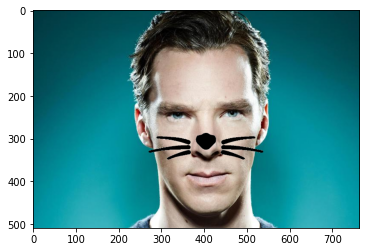

In [11]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---

# 다양한 사진에 적용해보기

## 1. 다양한 각도에 따른 스티커 적용

In [12]:
def find_landmark(name):
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/'+name+".png"
    print(my_image_path)
    img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

    # plt.imshow 이전에 RGB 이미지로 바꾸기
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    #plt.show()
    
    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
    dlib_rects = detector_hog(img_rgb, 1)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img_show, (l-10,t), (r,b+40), (0,255,255), 5, lineType=cv2.LINE_8)
    
    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    #plt.show()
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾기
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
          
        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img_show, point, 2, (10, 0, 255), -1)

        img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show_rgb)
        plt.show()

/aiffel/aiffel/camera_sticker/images/B-1.png


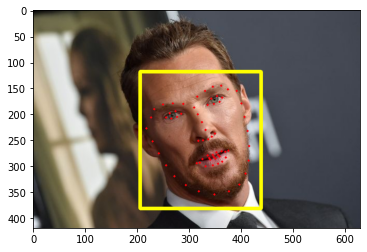

/aiffel/aiffel/camera_sticker/images/B-2.png
/aiffel/aiffel/camera_sticker/images/B-3.png


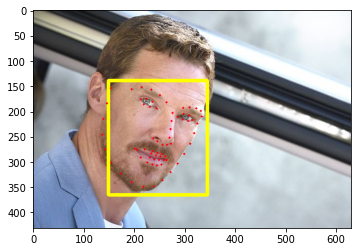

/aiffel/aiffel/camera_sticker/images/B-4.png


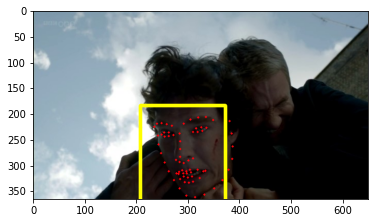

In [13]:
B_list = ['B-1','B-2','B-3','B-4']
for name in B_list :
    find_landmark(name)

/aiffel/aiffel/camera_sticker/images/B-2.png


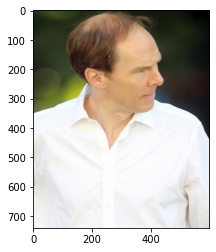

In [14]:
find_landmark('B-2')

**[문제점 발생] : 옆모습 얼굴일때 사진은 출력되지 않음**
* 얼굴 인식 불가하므로 바운딩 박스 및 얼굴 랜드마크가 적용되지 않아 출력되지 않고 넘어간것으로 보임

In [15]:
def cat_sticker(name):
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/'+name+".png"
    print(my_image_path)
    img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

    # plt.imshow 이전에 RGB 이미지로 바꾸기
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    #plt.show()
    
    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
    dlib_rects = detector_hog(img_rgb, 1)
    


    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img_show, (l-10,t), (r,b+40), (0,255,255), 5, lineType=cv2.LINE_8)
    
    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    #plt.show()
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾기
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img_show, point, 2, (10, 0, 255), -1)

        img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show_rgb)
        #plt.show()
        
    # 적용할 스티커 불러오기
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
    img_sticker_rgb = cv2.cvtColor(img_sticker,cv2.COLOR_BGR2RGB)

    

    #방법 2 . 수염의 중앙을 코 중심과 일치
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
            print(landmark[30]) # 코의 index는 30
            x = landmark[30][0]
            y = landmark[30][1] - dlib_rect.height()//2
            w = h = dlib_rect.width()           

    # 스티커 사진 크기 설정
    img_sticker = cv2.resize(img_sticker,(w,h))

    refined_x = x - w //2
    print('(x,y) : (%d,%d)'%(refined_x, y))

    #스티커가 이미지를 벗어났을 경우 스티커를 잘라내는 작업
    if refined_x < 0:
        img_sticker = img_sticker[:,-refined_x:]
        refined_x = 0

    if y < 0:
        img_sticker = img_sticker[-y:,:]
        y = 0
    
    sticker_area = img_bgr[y:y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[y:y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

/aiffel/aiffel/camera_sticker/images/B-1.png
(332, 230)
(x,y) : (220,118)


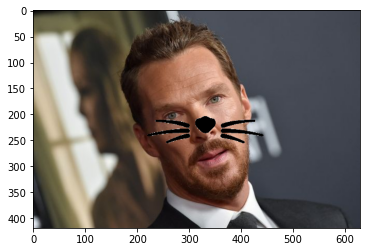

/aiffel/aiffel/camera_sticker/images/B-3.png
(270, 252)
(x,y) : (177,159)


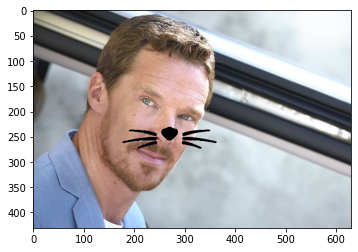

/aiffel/aiffel/camera_sticker/images/B-4.png
(285, 283)
(x,y) : (207,205)


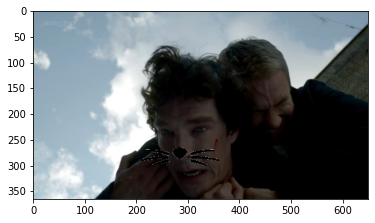

In [16]:
B_list1 = ['B-1','B-3','B-4']
for name in B_list1:
    cat_sticker(name)

**[문제 및 회고]**
* 얼굴 각도가 조금 틀어졌을 때는 얼굴 인식되어 해당 영역에 스티커가 적용됨
* 얼굴의 옆모습 및 90도 회전 이미지 등은 얼굴 영역 인식이 불가능하여 스티커 적용도 불가능함 
* 얼굴이 회전된만큼 스티커도 회전되어야 할 필요성이 있음

## 1.1 스티커 회전 시키기

In [22]:
# 회전 각 구하기 (호도법 참고)
import math
tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta *180/math.pi
print(rotate_angle)

2.935673446421173


In [18]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
#plt.imshow(img_rotate)
#plt.show()

(268, 268, 3)


In [19]:
def cat_sticker(name):
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/'+name+".png"
    print(my_image_path)
    img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
    img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

    # plt.imshow 이전에 RGB 이미지로 바꾸기
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
        
    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
    dlib_rects = detector_hog(img_rgb, 1)
    

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img_show, (l-10,t), (r,b+40), (0,255,255), 5, lineType=cv2.LINE_8)
    
    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    #plt.show()
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾기
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img_show, point, 2, (10, 0, 255), -1)

        img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show_rgb)
        #plt.show()
        
    tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
    theta = np.arctan(tan_theta)
    rotate_angle = theta *180/math.pi
    print(rotate_angle)
        
    # 적용할 스티커 불러오기
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
    img_sticker_rgb = cv2.cvtColor(img_sticker,cv2.COLOR_BGR2RGB)

    rotate_image(img_sticker,rotate_angle)
    img_rotate = rotate_image(img_sticker,rotate_angle)
    print(img_rotate.shape)
    plt.imshow(img_rotate)
    plt.show()
    
    #방법 2 . 수염의 중앙을 코 중심과 일치
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
            print(landmark[30]) # 코의 index는 30
            x = landmark[30][0]
            print('x : ',x)
            y = landmark[30][1] - dlib_rect.height()//2
            w = h = dlib_rect.width()           

    # 스티커 사진 크기 설정
    img_sticker = cv2.resize(img_rotate,(w,h))

    refined_x = x - w //2
    print('(x,y) : (%d,%d)'%(refined_x, y))

    #스티커가 이미지를 벗어났을 경우 스티커를 잘라내는 작업
    if refined_x < 0:
        img_sticker = img_sticker[:,-refined_x:]
        refined_x = 0

    if y < 0:
        img_sticker = img_sticker[-y:,:]
        y = 0

    sticker_area = img_bgr[y:y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[y:y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

/aiffel/aiffel/camera_sticker/images/B-1.png
27.0955524937518
(512, 512, 3)


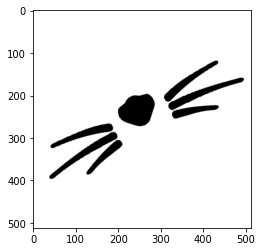

(332, 230)
x :  332
(x,y) : (220,118)


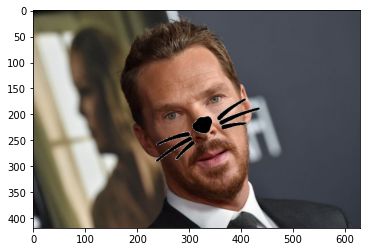

/aiffel/aiffel/camera_sticker/images/B-3.png
-6.981057406829795
(512, 512, 3)


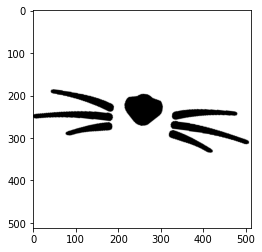

(270, 252)
x :  270
(x,y) : (177,159)


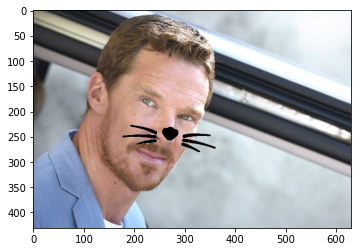

/aiffel/aiffel/camera_sticker/images/B-4.png
1.2730300200567113
(512, 512, 3)


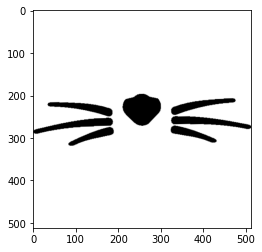

(285, 283)
x :  285
(x,y) : (207,205)


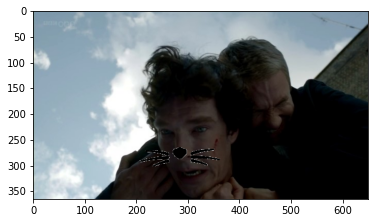

In [20]:
B_list1 = ['B-1','B-3','B-4']
for name in B_list1:
    cat_sticker(name)

**[해결했던 방향]**
* 얼굴 랜드마크의 코와 이마를 기준으로 호도법 사용하여 회전각을 찾고 스티커에 적용하여 원본사진에 덧붙여줌

**[문제점]**
* 90도 회전된 이미지의 바운딩 박스와 랜드마크 지정이 되지 않아 직관적으로 스티커 회전된 모습을 파악이 어려움
* 때문에 불러오는 스티커의 이미지 출력을 함께해서 적용이 잘 되었는지 확인함 
* <u>90도 회전 이미지의 바운딩 박스 및 랜드마크 찾는 법을 찾아 적용해 볼 예정_

## 2. 이미지 밝기에 따른 스티커 적용

/aiffel/aiffel/camera_sticker/images/Br-1.png
10.520784313874362
(512, 512, 3)


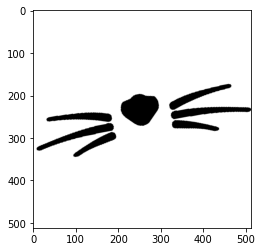

(283, 220)
x :  283
(x,y) : (149,86)


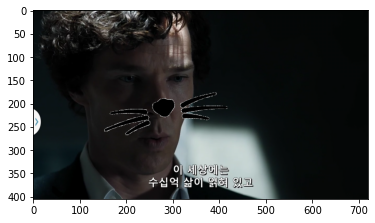

/aiffel/aiffel/camera_sticker/images/Br-2.png
0.0
(512, 512, 3)


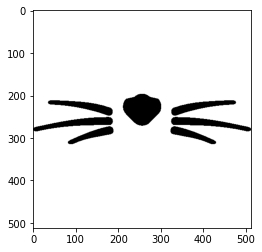

(337, 141)
x :  337
(x,y) : (272,76)


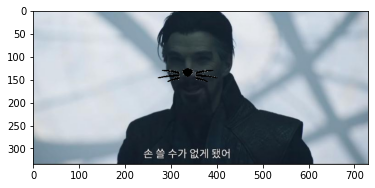

/aiffel/aiffel/camera_sticker/images/Br-3.png


UnboundLocalError: local variable 'landmark' referenced before assignment

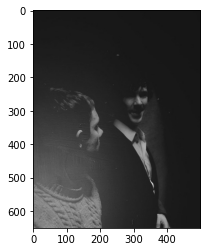

In [21]:
 B_list_light = ['Br-1','Br-2','Br-3']
for name in B_list_light:
    cat_sticker(name)

**[문제점]**
* 어두운 밝기의 이미지를 인식이 낮은거 같지 않음
* 단지, 블러효과때문에 잘 인식하지 않는게 아닌가 하고 추측함

/aiffel/aiffel/camera_sticker/images/Bd-1.png
-6.753574035530993
(512, 512, 3)


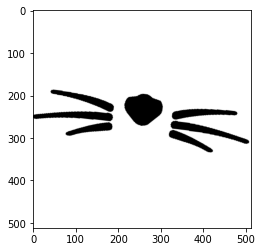

(782, 315)
x :  782
(x,y) : (449,-55)


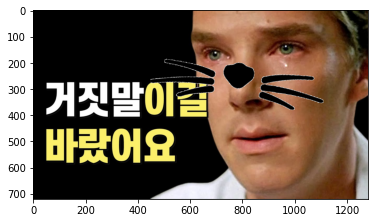

/aiffel/aiffel/camera_sticker/images/Bd-2.png
4.763641690726177
(512, 512, 3)


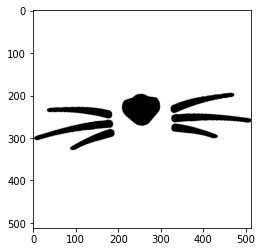

(381, 78)
x :  381
(x,y) : (355,52)


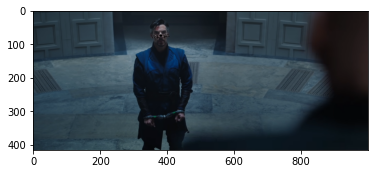

/aiffel/aiffel/camera_sticker/images/Bd-3.png
8.74616226255521
(512, 512, 3)


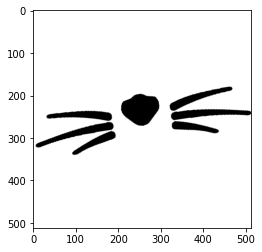

(146, 89)
x :  146
(x,y) : (81,24)


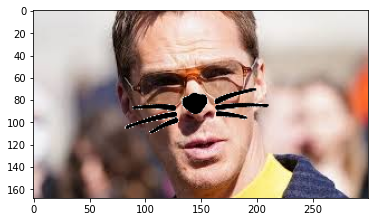

In [23]:
B_list_distance = ['Bd-1','Bd-2','Bd-3']
for name in B_list_distance:
    cat_sticker(name)

**[문제점]**
* 가까운 거리의 얼굴 이미지에서 스티커의 좌표값이 정확하게 들어 맞지 않는 현상이 보인다 
> 정확한 이유는 모르지만, refined 해주는 계산 식에서 문제가 있지 않을까 하는 추측이 있다 
> 또한 바운딩 박스의 경계와 이미지 경계와의 관계 연산시 일정 부분 오차가 발생해서 스티커 좌표 값도 달라지지 않았을까 하는 추측
> 위의 부분과 비슷한 맥락으로 face 랜드마크의 오차로 인한 부분일 수 있을 것이다.

**[결과회고]**
* 예상과 다르게 먼 거리의 있는 얼굴이 잘 인식되는 모습을 보여주었다
* 하지만, 정면이 아닌 약간의 측면이였다면 인식을 못하지 않았을까 하는 예상을 해보았고, 다른 사람들의 결과로 확인함.
> [참조 페이지] :https://ai-rtistic.com/2021/08/02/toy-project-camera-app/

* 더 나아가 안경과 같은 선글라스를 착용하여도 잘 인식되는 모습이다.

### 전체 회고

[위의 내용 이외]
* 이미지들 중 바운딩 박스가 인식되지 않는 부분은 페이스 랜드 마크 찾는 것도 안될 뿐더라 랜드마크 설정이 안되기 때문에 스티커 이미지가 특정 영역 및 특정 좌표값을 받지 못하여 그리지 못한다는 오류가 생기는것을 확인

* 바운딩 박스 및 랜드마크 검출할 때는 오류문이 없었지만, 스티커 적용시 발생함

* 오류문이 발생할 때 예외문 코드 작성을 통해 아무런 적용 없이 이미지 출력하는 방법을 찾을 예정

> 생각하는 방향성

>> 바운딩 박스를 그리지 않는 이미지에 조건문을 통해 걸러내기 (Continue)

>> 바운딩 박스는 그렸지만 랜드마크 검출이 안되는 부분을 조건문을 통해 걸러내기(Continue)